In [136]:
import numpy as np
import matplotlib.pyplot as plt


In [137]:
#ACTIVIDAD 1
#a. Estudio de Parámetros.
# - Al configurar K=0 y T=0.5 el valor aproximado de la entroía de Shannon es S=0.986.
# - Al aumentar K se observa que el punto crítico donde la interacción al ruido es K=1.0 en T=0.5
#   Es en este punto donde el parámetro de orden r se superpone (a veces) a la entropía de Shannon S.
#   Durante un tiempo son iguales en promedio (0.750, aproximadamente) y durante otro lapso r supera a
#   S signitificativamente (0.780 y 0.730, respectivamente).
# - Se usarán los valorse dichos previamente para validar el código hecho posteriormente.


In [138]:
#ACTIVIDAD 2

# a. Integrador Euler–Maruyama (Actividad 2a)
def euler_maruyama(dt, tmax, K, T, N=100, omega = np.random.normal(0, 0.5, 100)):
    #Número de pasos
    steps = int(tmax / dt)

    # Theta inicial
    theta = np.random.uniform(0, 2*np.pi, N)

    # Guardamos el estado inicial
    thetas = [theta.copy()]

    for n in range(steps):

        # Interacciones
        sin_term = np.sin(theta - theta[:, None])
        coupling = (K / N) * np.sum(sin_term, axis=1)

        # Ruido térmico
        noise = np.sqrt(2 * T * dt) * np.random.randn(N)

        # Paso
        theta += (omega + coupling) * dt + noise

        # Condición periódica (puesta por el enunciado)
        theta %= (2*np.pi)

        # Guardar copia del estado
        thetas.append(theta.copy())
    return thetas, omega



# b. Cálculo del parámetro de orden
def order_parameter(theta):
    theta = np.array(theta)
    Z = np.mean(np.exp(1j * theta))
    r = np.abs(Z)
    psi = np.angle(Z)
    return Z, r, psi

def compute_order_parameters(thetas):
    Z_values = []
    r_values = []
    psi_values = []
    for theta in thetas:
        Z, r, psi = order_parameter(theta)
        Z_values.append(Z)
        r_values.append(r)
        psi_values.append(psi)
    return Z_values, r_values, psi_values

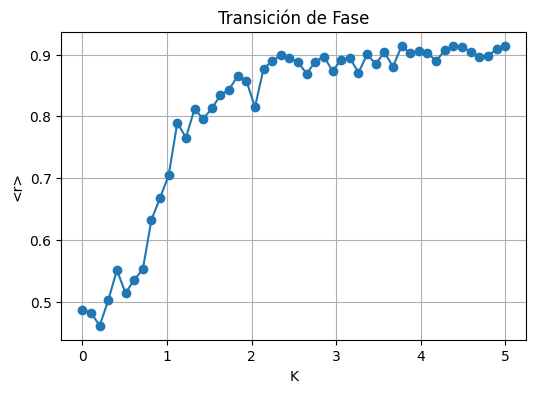

Kc numérico ≈ 1.0204081632653061


In [139]:
#ACTIVIDAD 3

#a. Transición de fase
#i. Gráfica <r> vs. K
r_means = []
Ks = np.linspace(0, 5, 50) #Variamos K de 0 a 5
for K in Ks:
    thetas = euler_maruyama(dt=0.01, tmax=20, K=K, T=0.1) #Fijamos T en 0.1
    r_values = compute_order_parameters(thetas)[1]

    # Promedio
    mean_r = np.mean(r_values)
    r_means.append(mean_r)
    
plt.figure(figsize=(6,4))
plt.plot(Ks, r_means, marker='o')
plt.xlabel("K")
plt.ylabel("<r>")
plt.title("Transición de Fase")
plt.grid(True)
plt.show()

#ii. Estimación numérica del punto crítico
idx = np.argmax(np.gradient(r_means))
Kc_num = Ks[idx]
print("Kc numérico ≈", Kc_num)

In [140]:
sigma = 0.5
g0 = 1.0 / (np.sqrt(2*np.pi) * sigma)
Kc_teorico = 2*0.1 + 2.0 / (np.pi * g0)
print("Kc teórico =", Kc_teorico)

Kc teórico = 0.9978845608028653


In [141]:
#Tras cada iteración, el K crítico resultante está acotado (aproximadamente) entre 0.8 y 1.0.
#El promedio es 0.9 aproximadamente, y el K crítico teórico es 0.998. Al compararlos, es evidente que
#a veces hay una diferencia significativa entre el resultado teórico y el calculado. Esto se debe al
#poco tiempo de simulación, la discretización y que se toma N = 100, cuando la teoría asume N->infinito.

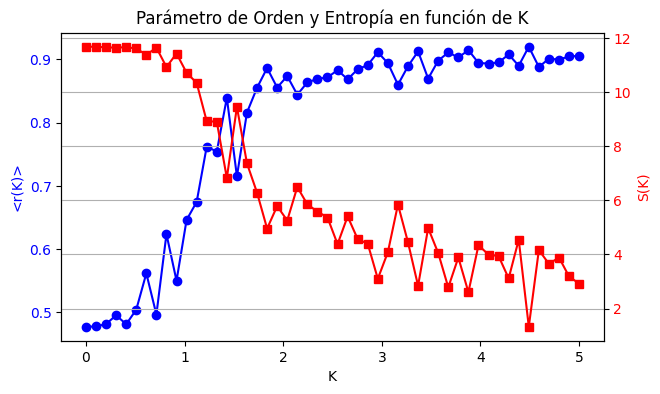

In [142]:
#b. Entropía e Información
#i. Entropía de Shannon
def shannon_entropy(theta, bins=40):
    hist, _ = np.histogram(theta, bins=bins, range=(0, 2*np.pi), density=True)
    P = hist[hist > 0]
    return -np.sum(P * np.log(P))

#ii. r y S vs. K
def entropy_vs_K(Ks, T, dt, tmax, N=100):
    r_final = []
    S_values = []
    
    i = 0
    for K in Ks:
        # Simulación
        thetas = euler_maruyama(N=N, dt=dt, tmax=tmax, K=K, T=T)
        
        # Parámetro de orden
        _, r_series, _ = compute_order_parameters(thetas)
        r_final.append(np.mean(r_series))   # Último valor porque r solo está definido en el estado estacionario, como vimos en clase.

        # Entropía en el estado final
        S_values.append(shannon_entropy(thetas[0])) # Último valor porque S solo está definido en el estado estacionario, como vimos en clase.
        i += 1


    return np.array(r_final), np.array(S_values)

r_K, S_K = entropy_vs_K(Ks, N=100, T=0.1, dt=0.01, tmax=20)

fig, ax1 = plt.subplots(figsize=(7,4))

# r(K)
ax1.plot(Ks, r_K, 'b-o', label='r(K)')
ax1.set_xlabel('K')
ax1.set_ylabel('<r(K)>', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# S(K)
ax2 = ax1.twinx()
ax2.plot(Ks, S_K, 'r-s', label='S(K)')
ax2.set_ylabel('S(K)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Parámetro de Orden y Entropía en función de K')
plt.grid(True)
plt.show()


In [143]:
# iii. Interpretación.
# Este sistema se puede interpretar como un conjunto de osciladores acoplados con interacción atractiva
# K, sometidos a ruido térmico T. En esta analogía:
# U es energía interna asociada a la sincronización (es menor cuando los osciladores se alinean: r es grande)
# S es entropía asociada a la distribución de fases (máxima cuando las fases son uniformes, mínima cuando se agrupan)
# Así, F = U − TS es la energía libre que el sistema trata de minimizar a todo costa.
# Antes de K_c el acoplamiento entre osciladores es insuficiente para compensar el desorden térmico. 
# Esto hace que el término -TS domine la energía libre F, favoreciendo la entropía alta y la distribución 
# uniforme de fases. Al cruzar K_c, el acoplamiento K reduce la energía interna U de manera significativa 
# si los osciladores se alinean. A partir de ese punto, la disminución en U supera el costo entrópico de 
# ordenar al sistema, haciendo que la energía libre disminuya si el sistema se sincroniza. Por eso, 
# el sistema “elige” reducir su entropía: el estado sincronizado tiene menor F. Este cambio abrupto 
# corresponde a la transición de fase observada en <r> y la caída de entropía S.

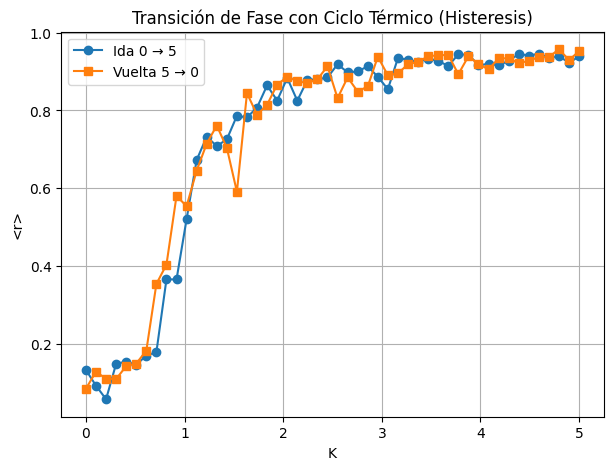

In [144]:
# 4. Path-dependence

r_means_up = []
r_means_down = []

Ks_up = np.linspace(0, 5, 50)      # Ida: 0 a 5
Ks_down = np.linspace(5, 0, 50)    # Vuelta: 5 a 0


# Ida
for K in Ks_up:

    thetas, omega = euler_maruyama(dt=0.01, tmax=20, K=K, T=0.1)
    r_values = compute_order_parameters(thetas)[1]

    mean_r = np.mean(r_values)
    r_means_up.append(mean_r)


# Vuelta
for K in Ks_down:

    thetas, omega = euler_maruyama(dt=0.01, tmax=20, K=K, T=0.1)
    r_values = compute_order_parameters(thetas)[1]

    mean_r = np.mean(r_values)
    r_means_down.append(mean_r)


# Gráfica combinada
plt.figure(figsize=(7,5))
plt.plot(Ks_up,   r_means_up,   marker='o', label="Ida 0 → 5")
plt.plot(Ks_down, r_means_down, marker='s', label="Vuelta 5 → 0")
plt.xlabel("K")
plt.ylabel("<r>")
plt.title("Transición de Fase con Ciclo Térmico (Histeresis)")
plt.grid(True)
plt.legend()
plt.show()


In [145]:
# Las curvas de <r> en la ida y en la vuelta se superponen dentro del error estadístico, 
# indicando que el sistema no presenta histéresis.
# Esto es consistente con el hecho de que el modelo de acoplamiento sinusoidal posee una transición continua 
# (de segundo orden), sin múltiples mínimos locales de energía libre que permitan dependencia del camino.